In [ ]:
import sys
sys.path.append('../')
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from google.colab import drive

drive.mount('/content/drive')
# Изменим стандартный размер графиков matplotlib
WIDTH_SIZE = 15
HEIGHT_SIZE = 10
plt.rcParams["figure.figsize"] = [WIDTH_SIZE, HEIGHT_SIZE]

Mounted at /content/drive


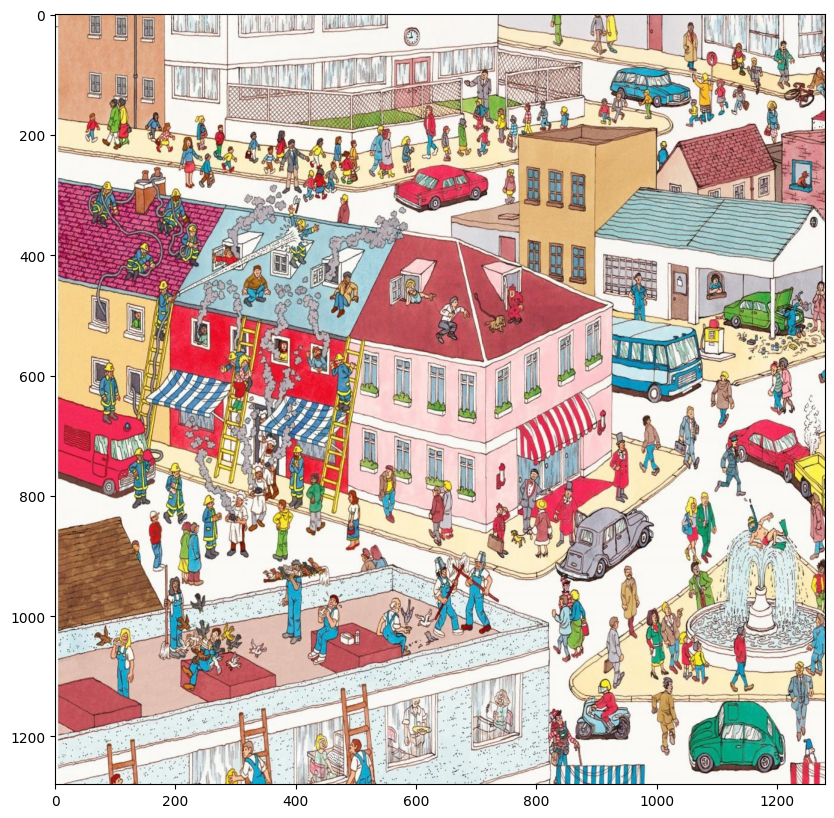

In [ ]:
# Загружаем изображение
brg_scene = cv2.imread('/content/drive/My Drive/Colab_Notebooks/COI/img.jpg')
plt.figure()
plt.imshow(cv2.cvtColor(brg_scene, cv2.COLOR_BGR2RGB))
# Преобразуем изображение в оттенки серого
gray_img_scene = cv2.cvtColor(brg_scene, cv2.COLOR_BGR2GRAY)

# Загружаем шаблон
template_brg = cv2.imread('/content/drive/My Drive/Colab_Notebooks/COI/template.jpg')
plt.figure()
plt.imshow(cv2.cvtColor(template_brg, cv2.COLOR_BGR2RGB))

# Преобразуем в оттенки серого
gray_templ = cv2.cvtColor(template_brg, cv2.COLOR_BGR2GRAY)

60 40


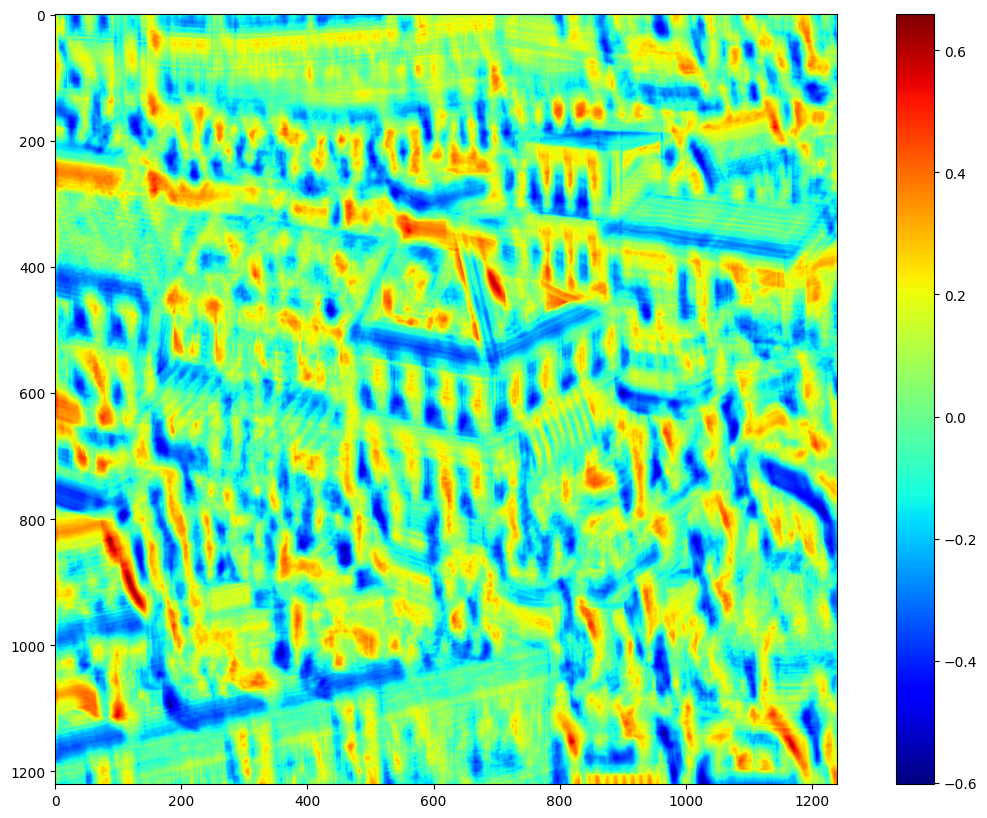

In [16]:
# Считаем размеры шаблона
w, h = template_brg.shape[:-1]

# Вызываем функцию cv2.matchTemplate для вычисления метрики схожести
# в качестве параметров передаем изображение, шаблон и тип вычисляемой метрики
res = cv2.matchTemplate(gray_img_scene,gray_templ,cv2.TM_CCOEFF_NORMED)
print(w, h)
# Возможные варианты метрик:
#    cv2.TM_SQDIFF — сумма квадратов разниц значений пикселей
#    cv2.TM_SQDIFF_NORMED — сумма квадрат разниц цветов, отнормированная в диапазон 0..1.
#    cv2.TM_CCORR — сумма поэлементных произведений шаблона и сегмента картинки
#    cv2.TM_CCORR_NORMED — сумма поэлементных произведений, отнормированное в диапазон -1..1.
#    cv2.TM_CCOEFF — кросс-коррелация изображений без среднего
#    cv2.TM_CCOEFF_NORMED — кросс-корреляция между изображениями без среднего, отнормированная в -1..1 (корреляция Пирсона)
plt.figure()
plt.imshow(res, cmap='jet')
plt.colorbar()

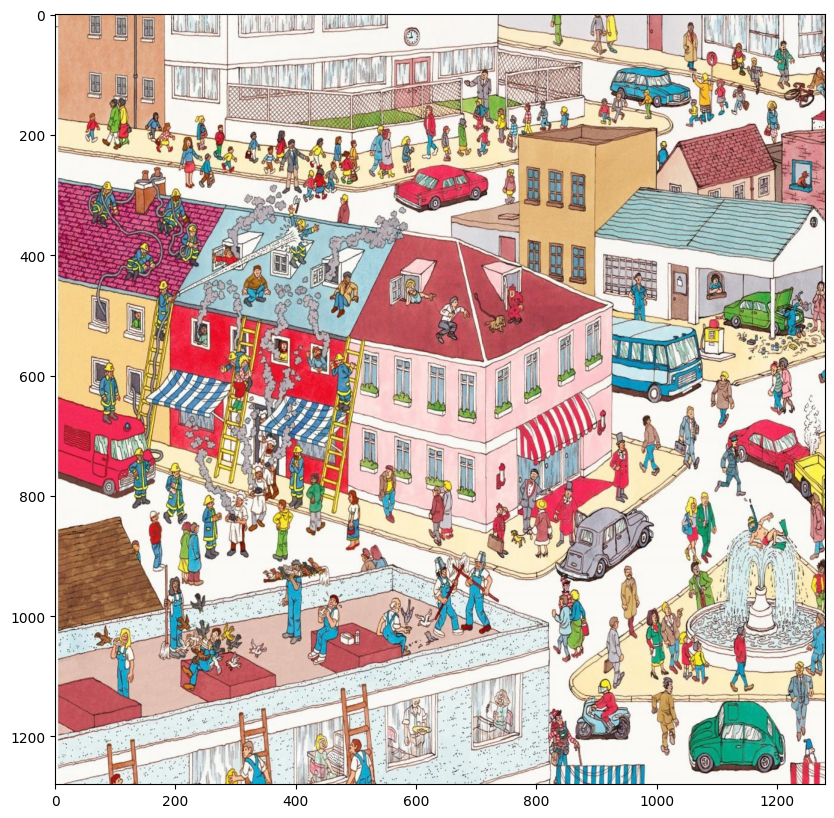

In [ ]:
threshold = 0.8
loc = np.where(res >= threshold)
# Вокруг выделенных максимумов обводим прямоугольники с размерами шаблона
plot_img = brg_scene.copy()
for pt in zip(*loc[::-1]):
    cv2.rectangle(plot_img, pt,(pt[0] + w, pt[1] + h),(173,255,47), 8)

# Отображаем результат на графике
plt.figure()
plt.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))

(Text(0.5, 1.0, 'Sobel'), ([], []), ([], []))

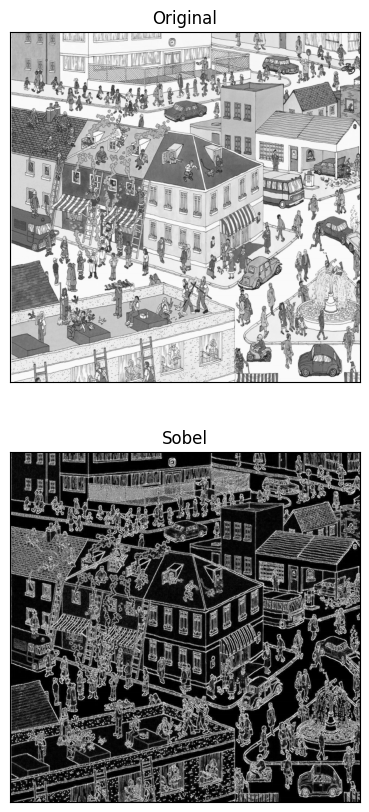

In [ ]:
imgG = cv2.cvtColor(brg_scene, cv2.COLOR_BGR2GRAY)



x = cv2.Sobel(imgG,cv2.CV_16S,1,0)
y = cv2.Sobel(imgG,cv2.CV_16S,0,1)

# берем модуль от результата применения фильтра Собеля
absX = cv2.convertScaleAbs(x)
absY = cv2.convertScaleAbs(y)

# объединяем "вертикальные" и "горизонтальные" границы в одно изображение
dstI = cv2.addWeighted(absX,0.5,absY,0.5,0)
plt.figure()
plt.subplot(2,1,1),plt.imshow(imgG,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,1,2),plt.imshow(dstI,cmap = 'gray')
plt.title('Sobel'), plt.xticks([]), plt.yticks([])

(Text(0.5, 1.0, 'Sobel'), ([], []), ([], []))

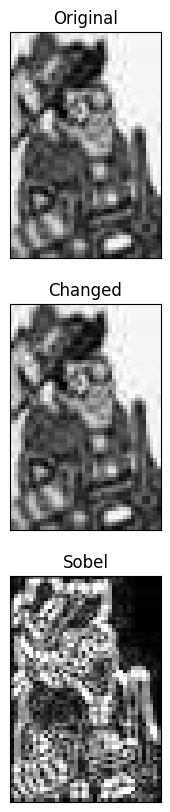

In [ ]:
tmpG = gray_templ
x = cv2.Sobel(tmpG,cv2.CV_16S,1,0)
y = cv2.Sobel(tmpG,cv2.CV_16S,0,1)
absX = cv2.convertScaleAbs(x)
absY = cv2.convertScaleAbs(y)
dstT = cv2.addWeighted(absX,0.5,absY,0.5,0)

plt.subplot(3,1,1),plt.imshow(gray_templ,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(3,1,2),plt.imshow(tmpG,cmap = 'gray')
plt.title('Changed'), plt.xticks([]), plt.yticks([])
plt.subplot(3,1,3),plt.imshow(dstT,cmap = 'gray')
plt.title('Sobel'), plt.xticks([]), plt.yticks([])

In [ ]:
w, h = tmpG.shape

# Вычисляем метрику схожести
res = cv2.matchTemplate(dstI,dstT,cv2.TM_CCOEFF_NORMED)
plt.figure(figsize=(WIDTH_SIZE,HEIGHT_SIZE))
plt.imshow(res, cmap='jet')
plt.colorbar()

#  Отбираем максимумы и строим результат на графике
threshold = 0.7
loc = np.where(res >= threshold)
plot_img = brg_scene.copy()
for pt in zip(*loc[::-1]):
    cv2.rectangle(plot_img, pt,(pt[0] + w, pt[1] + h),(173,255,47), 8)

plt.figure(figsize=(WIDTH_SIZE,HEIGHT_SIZE))
plt.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))

Output hidden; open in https://colab.research.google.com to view.

(5.92751407623291, 985.7771606445312)
1.821510672569275
180.57814025878906
0.034854792058467865
1.821510672569275


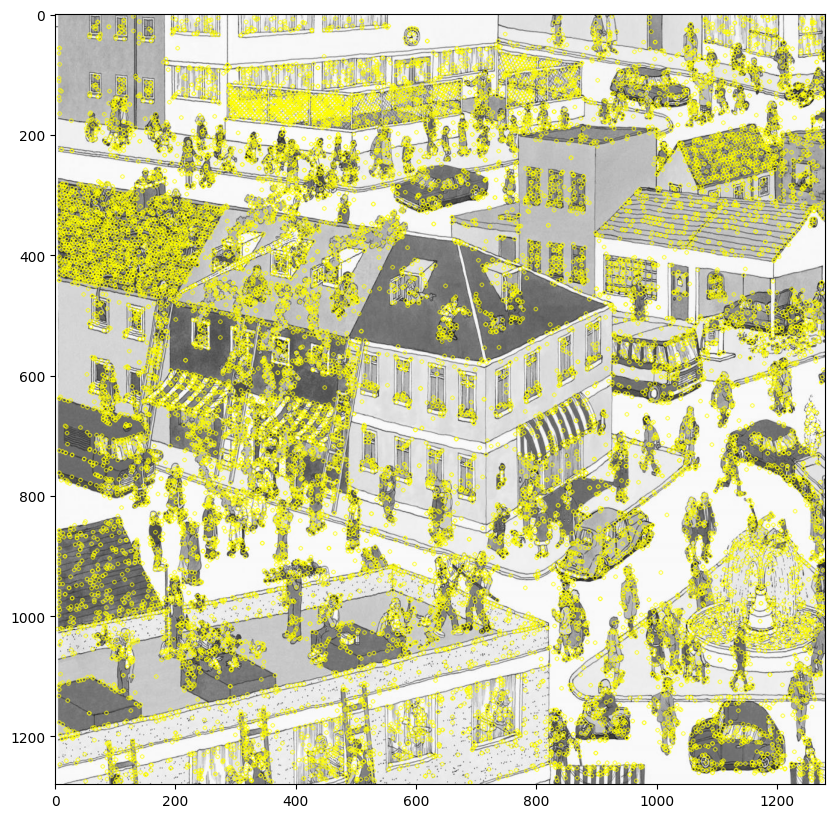

In [ ]:
# Преобразуем и вносим небольшие изменения в шаблон

    # Преобразуем в оттенки серого
scale = 1.1 # масштаб изменения размеров
scBr = 0.9 # коэффициент изменения яркости

template_scale = cv2.resize(np.uint8(0.9*gray_templ),
           (int(gray_templ.shape[1]*scale), int(gray_templ.shape[0]*scale)), interpolation = cv2.INTER_AREA)

# Создаем детектор особых точек
sift = cv2.SIFT_create()
# sift = cv2.xfeatures2d.SIFT_create() # В зависимости от версии opencv может работать эта команда

# Запускаем детектор на изображении и на шаблоне
# Метод возвращает список особых точек и их дескрипторов
k_1, des_1 = sift.detectAndCompute(gray_img_scene, None)
k_2, des_2 = sift.detectAndCompute(template_scale, None)

# Каждая особая точка имеет несколько параметров, таких как координаты,
# размер, угол ориентации, мощность отклика и размер области особой точки.
print(k_1[1].pt)
print(k_1[1].size)
print(k_1[1].angle)
print(k_1[1].response)
print(k_1[1].size)

# Отрисуем найденные точки на картинке
image_key_point = cv2.drawKeypoints(gray_img_scene, k_1, des_1, (0, 255, 255))
plt.figure()
plt.imshow(cv2.cvtColor(image_key_point, cv2.COLOR_BGR2RGB))

# Отрисуем найденные точки на шаблоне
template_key_point = cv2.drawKeypoints(template_scale, k_2, des_2, (0, 255, 255))
plt.figure()
plt.imshow(cv2.cvtColor(template_key_point, cv2.COLOR_BGR2RGB))

plt.figure()
plt.imshow(gray_templ, cmap="gray")

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)


matches = bf.match(des_1, des_2)

print(matches[1].queryIdx)
print(matches[1].trainIdx)
print(matches[1].distance)

1070
28
2358.0


In [ ]:
print(k_1[matches[1].queryIdx].size)
matches = sorted(matches, key=lambda x: x.distance)
image_with_matches = cv2.drawMatches(gray_img_scene, k_1, template_scale, k_2, matches[:20], template_scale, flags=2)
plt.figure()
plt.imshow(cv2.cvtColor(image_with_matches, cv2.COLOR_BGR2RGB))

2.7479248046875


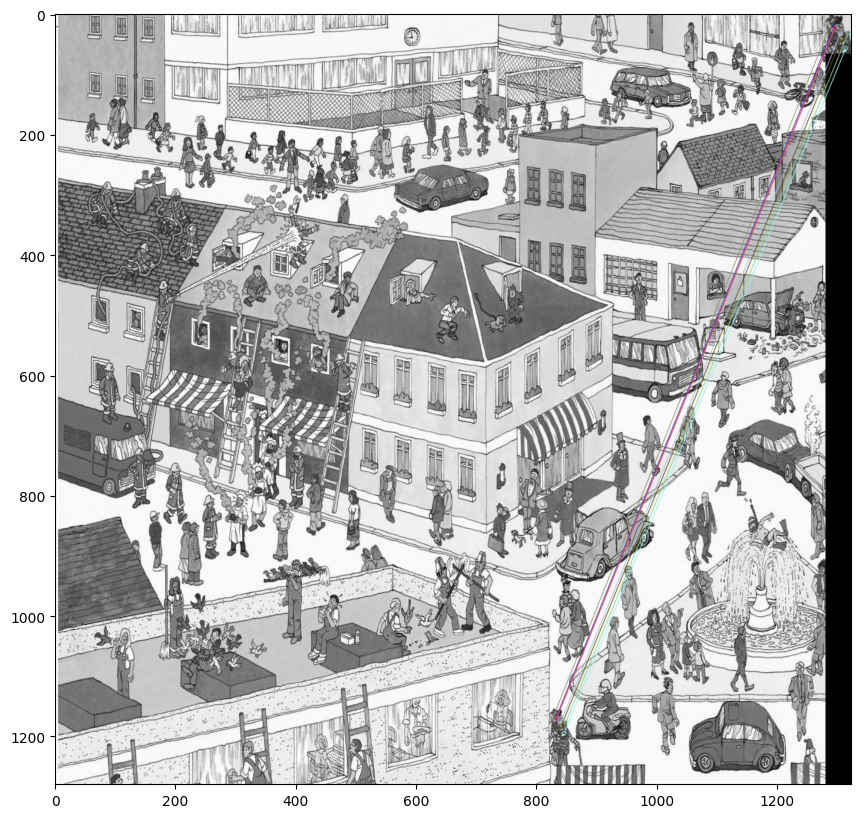

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L1)
matches = bf.knnMatch(des_1, des_2, k=2)

# Лучшие пары особых точек отбираются с использованием теста отношения правдоподобия
good = []
for m, n in matches:
    if m.distance < 0.4 * n.distance:
        good.append([m])

# построим совпадения на изображении
image_with_knn_matches = cv2.drawMatchesKnn(gray_img_scene,k_1,template_scale,k_2,good[:200],None,flags=2)
plt.figure()
plt.imshow(cv2.cvtColor(image_with_knn_matches, cv2.COLOR_BGR2RGB))

In [37]:
# Сопоставление дескрипторов с использованием BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L1)
matches = bf.knnMatch(des_1, des_2, k=2)

# Применяем тест на соотношение для поиска лучших совпадений
good = []
for m, n in matches:
    if m.distance < 0.38 * n.distance:
        good.append(m)

# Убедимся, что найдено достаточно совпадений для вычисления гомографии
if len(good) > 2:
    # Извлекаем координаты соответствующих ключевых точек
    src_pts = np.float32([k_1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([k_2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Вычисляем гомографию
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    if M is not None:
        print("Матрица гомографии:\n", M)

        # Получаем углы шаблона
        h, w = template_scale.shape[:2]
        corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

        # Преобразуем углы с помощью гомографии
        transformed_corners = cv2.perspectiveTransform(corners, M) * -1
        print("Трансформированные углы:\n", transformed_corners)

        # Убедимся, что углы корректны
        if transformed_corners is not None and len(transformed_corners) > 0:
            # Преобразуем углы в одномерный массив для удобства
            transformed_corners = transformed_corners.reshape(-1, 2)

            # Находим минимальные и максимальные значения координат
            x_min, y_min = np.min(transformed_corners, axis=0)
            x_max, y_max = np.max(transformed_corners, axis=0)

            # Печать координат для отладки
            print(f"x_min: {x_min}, y_min: {y_min}, x_max: {x_max}, y_max: {y_max}")

            # Ограничиваем координаты в пределах изображения
            x_min = max(0, int(x_min))
            y_min = max(0, int(y_min))
            x_max = min(gray_img_scene.shape[1], int(x_max))
            y_max = min(gray_img_scene.shape[0], int(y_max))

            # Печать итоговых координат
            print(f"Итоговые координаты после паддинга и ограничения: x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")

            # Отрисовываем прямоугольник на изображении сцены
            image_with_rectangle = cv2.rectangle(brg_scene.copy(),
                                                 (x_min +5, y_min),
                                                 (x_max -40 , y_max),
                                                 (0, 0, 255), 2)  # Красный прямоугольник

            # Отображаем совпадения для визуализации
            image_with_knn_matches = cv2.drawMatchesKnn(brg_scene, k_1, template_scale, k_2, [[m] for m in good], None, flags=2)

            # Показать результат
            plt.figure()
            plt.imshow(cv2.cvtColor(image_with_knn_matches, cv2.COLOR_BGR2RGB))
            plt.figure()
            plt.imshow(cv2.cvtColor(image_with_rectangle, cv2.COLOR_BGR2RGB))
            plt.show()

        else:
            print("Трансформированные углы невалидны")
    else:
        print("Гомография не может быть вычислена")
else:
    print(f"Не найдено достаточно совпадений - {len(good)}/3")


Output hidden; open in https://colab.research.google.com to view.